In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor

import os


In [2]:
# noise_type = "class_independent"
# fixed_class = 0
# fixed_noise = 0.0
# misspecify = "correct"
# model_type = "NN"
# dataset = "cshock_eicu"



# for dataset in tqdm(["cshock_eicu_imbalanced", "cshock_mimic_imbalanced", "cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer", "saps_imbalanced", "support_imbalanced", "lungcancer_imbalanced"]):
#     for model_type in ["LR", "NN"]:
#         for noise_type in ["class_independent", "class_conditional"]:

#             try:
#                 data = calculate_metrics_abstain(dataset, noise_type = noise_type, fixed_class=fixed_class, fixed_noise = fixed_noise, misspecify = misspecify)
#                 data.to_csv(f"/h/snagaraj/noise_multiplicity/results/abstain_metrics_{dataset}_{noise_type}_{model_type}_{fixed_class}_{fixed_noise}_{misspecify}.csv")
#                 print(dataset)
#                 #plot_metrics(data)
#             except:
#                 continue

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
dataset = "cshock_eicu"
model_type = "LR"  # Set model type as fixed
noise_type = "class_conditional"  # Set noise type as fixed
fixed_class = 0  # Fixed class parameter
fixed_noise = 0.0  # Fixed noise parameter
noise_level = 0.2
misspecify = "correct"  # Set misspecification level


data = calculate_metrics_abstain(dataset, noise_type = noise_type, fixed_class=fixed_class, fixed_noise = fixed_noise, misspecify = misspecify)
data           

AttributeError: 'DataFrame' object has no attribute 'unanticipated_mistake'

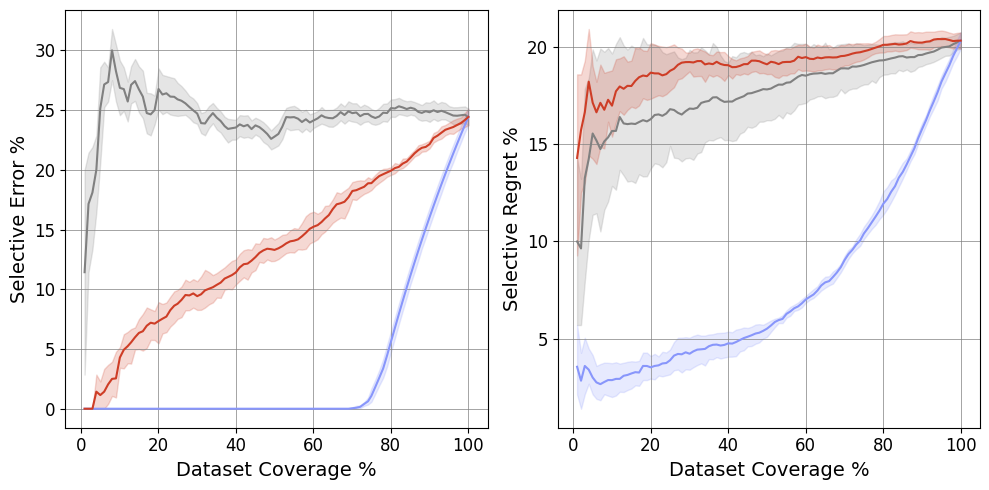

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

# List of datasets and renamed titles
datasets = ["cshock_eicu", "cshock_mimic", "support", "lungcancer"]
dataset_titles = {
    "cshock_eicu": "shock_eicu",
    "cshock_mimic": "shock_mimic",
    "saps": "mortality",
    "support": "support",
    "lungcancer": "lungcancer"
}


# Metrics to plot
metrics = ["regret", "clean_risk_test"]

# Define your custom color palette for each method
method_colors = {
    "New": "#8896FB",  # Purple
    "Unanticipated": "#808080",  # Gray
    "Confidence": "#ce3d26"  # Red
}

y_labels = {"regret": "Selective Regret %",
           "clean_risk_test": "Selective Error %"}

# Create a figure with 2 rows (one for each metric) and 6 columns (one for each dataset)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

dataset = "cshock_eicu"
# Loop through each dataset and plot the metrics
for idx, metric in enumerate(["clean_risk_test", "regret"]):

    # Read the data for the dataset
    #data = pd.read_csv(f"/h/snagaraj/noise_multiplicity/results/abstain_metrics_{dataset}_{noise_type}_{model_type}_{fixed_class}_{fixed_noise}_{misspecify}.csv")
    #data = pd.read_csv(f"/h/snagaraj/noise_multiplicity/results/abstain_metrics_{dataset}_{noise_type}_{model_type}_{noise_level}_{misspecify}.csv")

    # Capitalize first letter of the method names to match color mapping
    data['method'] = data['method'].str.capitalize()

    data["abstention"] = data["coverage"]

    # Subset data based on loss_type and noise_level if needed
    loss_type = "BCE"
    noise_level = 0.2
    sub_data = data[(data["loss"] == loss_type) & (data["noise"] == noise_level)]

    # Plot each metric in its respective position in the grid

    ax = axes[idx]

    # For each method, plot the line for the selected metric
    for method in sub_data['method'].unique():
        if method != "Ambiguity":
            method_data = sub_data[(sub_data['method'] == method) & (sub_data['metric'] == metric)]
            sns.lineplot(data=method_data, x="abstention", y="value", ax=ax, color=method_colors.get(method, "#808080"), label=method)

    # Set labels and grid
    ax.set_xlabel("Dataset Coverage %", fontsize=14)

    ax.set_ylabel(y_labels[metric], fontsize=14)
    ax.yaxis.get_major_locator().set_params(integer=True)

    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Remove individual plot legends
    ax.legend().remove()

   

plt.tight_layout()

#plt.savefig('/h/snagaraj/noise_multiplicity/figures/abstain.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()